In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.weightstats import *
from statsmodels.stats.descriptivestats import sign_test
import matplotlib.pylab as plt
import itertools

In [2]:
seattle_data = pd.read_csv('seattle.txt', header=0, sep='\t')
seattle_data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


In [3]:
price2001 = seattle_data[seattle_data['Year'] == 2001].Price
price2002 = seattle_data[seattle_data['Year'] == 2002].Price

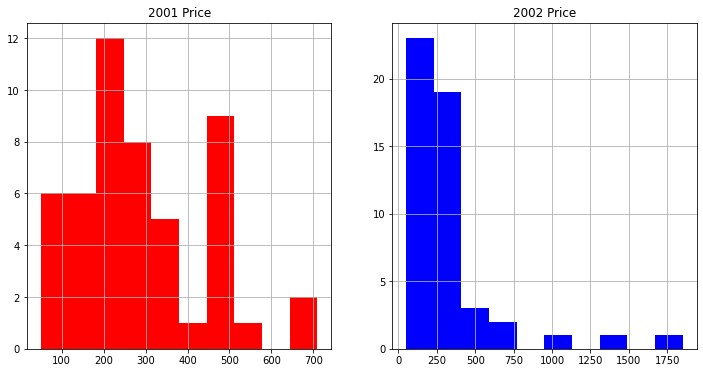

In [4]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('2001 Price')
plt.grid()
plt.hist(price2001, color='r')
plt.subplot(1,2,2)
plt.grid()
plt.title('2002 Price')
plt.hist(price2002, color='b')
plt.show()

H0 - Медианы двух выборок совпадают

H1 - Медианы не совпадают

In [5]:
#   Доверительный интервал для среднего
print(zconfint(price2001))
print(zconfint(price2002))

(245.19358064978286, 332.65949935021723)
(241.4379457326015, 417.07633426739847)


### Ранговый критерий Манна-Уитни

H0: P(X>Y) = P(Y>X)

H1: P(X>Y) <=> P(Y>X)

In [6]:
stats.mannwhitneyu(price2001, price2002)

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

### Перестановочный критерий
H0: F_1(X) = F_2(X)
H1: F_1(X) = F_2(X + delta)

In [7]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations=max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n)))
                   for index in itertools.combinations(range(n), n1)]
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() for i in indices]
    return distr

(array([  5.,  15.,  82., 148., 210., 216., 161., 118.,  35.,  10.]),
 array([-150.18504 , -120.894816,  -91.604592,  -62.314368,  -33.024144,
          -3.73392 ,   25.556304,   54.846528,   84.136752,  113.426976,
         142.7172  ]),
 <BarContainer object of 10 artists>)

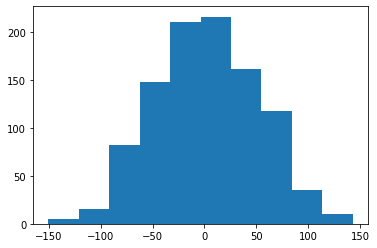

In [8]:
plt.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations=1000))

In [9]:
def permutation_test(sample, mean, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError('Unknown alternative')
    t_stat = permutation_t_stat_ind(sample, mean)
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [10]:
permutation_test(price2001, price2002, max_permutations=10000)

0.4421

In [11]:
permutation_test(price2001, price2002, max_permutations=100000)

0.44129